In [54]:
import numpy as np
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, Angle
from astropy.coordinates import EarthLocation
import pytz
from astroplan import Observer, FixedTarget
from astropy.utils.iers import conf
conf.auto_max_age = None
from astropy.coordinates import get_sun, get_moon, get_body
from astroplan import moon_illumination
from matplotlib import dates

import matplotlib.pyplot as plt
from astroplan.plots import plot_sky, plot_airmass
from astroplan import EclipsingSystem
from astroplan import (PrimaryEclipseConstraint, is_event_observable,
                       AtNightConstraint, AltitudeConstraint, LocalTimeConstraint, AirmassConstraint)

from astroplan import download_IERS_A 
download_IERS_A()

from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive

In [56]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)
plt.style.use('dark_background')

# Q1

In [3]:
location = EarthLocation.of_site("Apache Point Observatory")

In [18]:
apo = Observer(location=location, timezone="US/Mountain")

In [19]:
apo

<Observer: location (lon, lat, el)=(-105.82000000000002 deg, 32.78000000000001 deg, 2797.9999999996007 m),
    timezone=<DstTzInfo 'US/Mountain' LMT-1 day, 17:00:00 STD>>

# Q2

In [12]:
sept = Time("2022-09-19")

In [22]:
sunset = apo.sun_set_time(sept, which="next")

In [23]:
sunset.iso

'2022-09-19 01:01:13.535'

In [26]:
(sunset - 6 * u.hour).iso

'2022-09-18 19:01:13.535'

# Q3

In [38]:
utc_time = Time("2022-09-19 23:30:00", location=location) + 7 * u.hour

In [41]:
utc_time.sidereal_time('mean')

<Longitude 23.38777051 hourangle>

# Q5

In [48]:
apo.moon_rise_time(sept, which="next").iso

'2022-09-19 06:48:58.649'

# Q8

In [50]:
location = EarthLocation.of_site("Manastash Ridge Observatory")
mro = Observer(location=location, timezone="US/Pacific")

In [64]:
targets = [
    SkyCoord(ra="12h35m26.4s", dec="+14d29m47s"),
    SkyCoord(ra="15h05m16.0s", dec="+55d49m40s"),
]

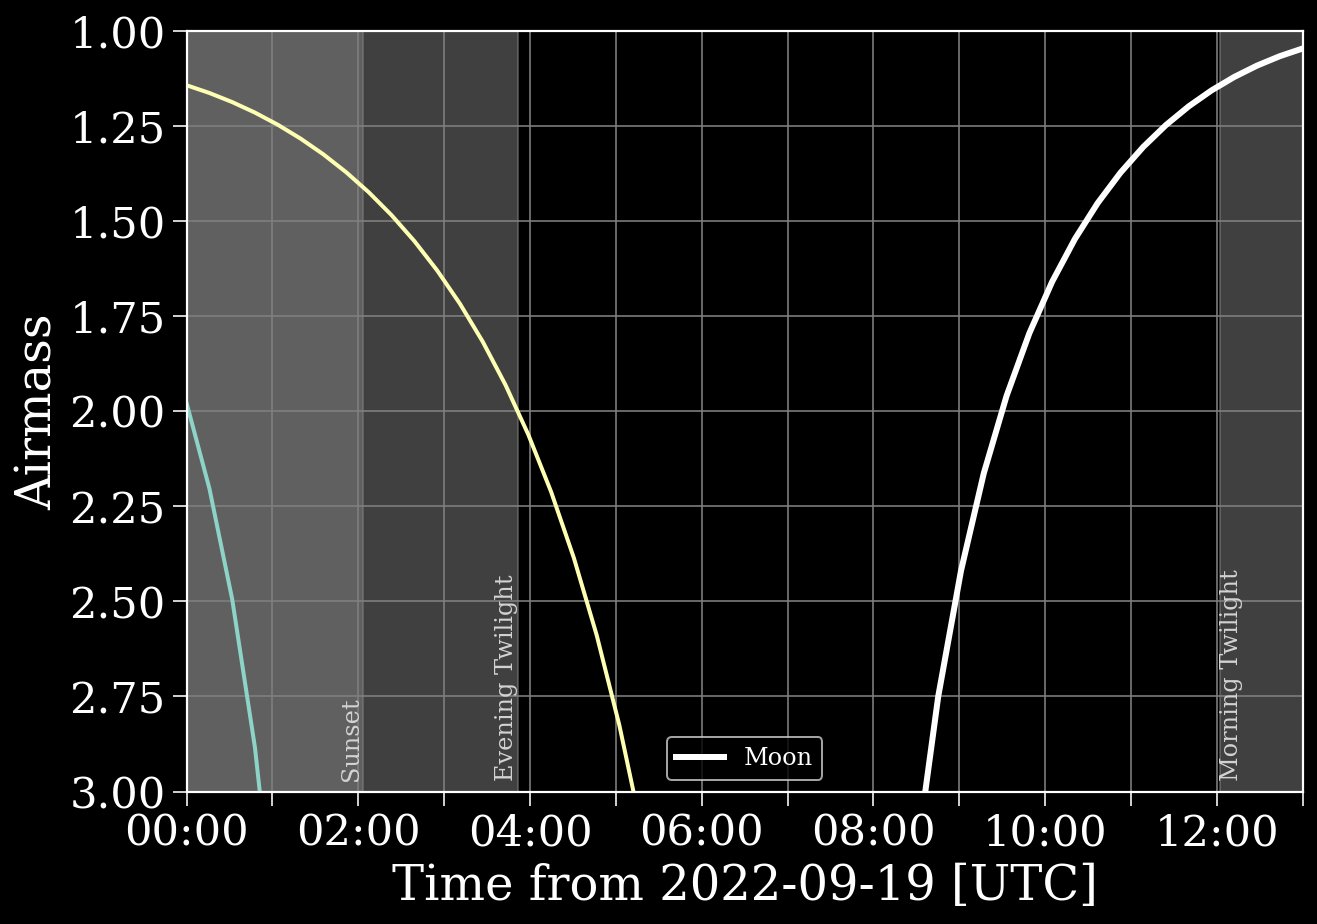

In [77]:
fig, ax = plt.subplots(figsize=(10, 7))

day = 19

obs_time = Time(f"2022-09-{day}")
sunset = mro.sun_set_time(obs_time, which='nearest')
eve_twil = mro.twilight_evening_astronomical(obs_time, which='nearest')
midnight = mro.midnight(obs_time, which='next')
morn_twil = mro.twilight_morning_astronomical(obs_time, which='next')
sunrise = mro.sun_rise_time(obs_time, which='next')

t_start = Time(f"2022-09-{day} 00:00:00")
t_end = Time(f"2022-09-{day} 13:00:00")

# space observation times during dark time
t_observe = t_start + (t_end - t_start) * np.linspace(0.0, 1.0, 50)

# work out where the moon is and plot it
moon = get_moon(t_observe)
moon_airmass = apo.altaz(t_observe, moon).secz
ax.plot(t_observe[moon_airmass >= 1].plot_date, moon_airmass[moon_airmass >= 1],
        label="Moon", color="white", lw=3)

# plot each system
for target in targets:

    if hasattr(t_observe, 'utcoffset') and use_local_tz:
        tzoffset = t_observe.utcoffset()
        tzname = t_observe.tzname()
        tzinfo = t_observe.tzinfo
    else:
        tzoffset = 0 * u.day
        tzname = 'UTC'
        tzinfo = None

    timetoplot = t_observe + tzoffset
    airmass = apo.altaz(t_observe, target).secz

    ax.plot(timetoplot[airmass >= 1].plot_date, airmass[airmass >= 1], lw=2)

ax.set_ylim(3, 1)
ax.grid(color="grey")

ax.axvspan(t_start.plot_date, sunset.plot_date, color="grey", alpha=0.5)
ax.axvspan(t_start.plot_date, eve_twil.plot_date, color="grey", alpha=0.5)

ax.annotate("Sunset", xy=(sunset.plot_date, 2.97), ha="right", va="bottom", rotation=90, fontsize=0.5*fs, color="lightgrey")
ax.annotate("Evening Twilight", xy=(eve_twil.plot_date, 2.97), ha="right", va="bottom", rotation=90, fontsize=0.5*fs, color="lightgrey")
ax.annotate("Morning Twilight", xy=(morn_twil.plot_date, 2.97), ha="left", va="bottom", rotation=90, fontsize=0.5*fs, color="lightgrey")

ax.axvspan(morn_twil.plot_date, t_end.plot_date, color="grey", alpha=0.5)
ax.axvspan(sunrise.plot_date, t_end.plot_date, color="grey", alpha=0.5)


ax.legend(fontsize=0.7*fs, loc="upper left")

ax.set_xlim([t_start.plot_date, t_end.plot_date])
ax.set_xticks([Time(f"2022-09-{day} {i:02d}:00:00").plot_date for i in range(0, 13 + 1)])
ax.set_xticklabels([f'{Time(f"2022-09-{day} {i:02d}:00:00").ymdhms[3]:02d}:00' if i % 2 == 0 else "" for i in range(0, 13 + 1)])

ax.legend(fontsize=0.5*fs)

ax.set_ylabel("Airmass")
ax.set_xlabel("Time from {0} [{1}]".format(min(timetoplot).datetime.date(), tzname))

plt.savefig("mro_galaxies.pdf", format="pdf", bbox_inches="tight")

plt.show()

# Q10 

In [71]:
mro.twilight_morning_astronomical(obs_time, which="next").iso

'2022-09-19 12:02:19.635'

# Q11

In [76]:
for target in targets:
    print(target.transform_to("galactic"))

<SkyCoord (Galactic): (l, b) in deg
    (285.69227417, 76.82963912)>
<SkyCoord (Galactic): (l, b) in deg
    (92.28601081, 52.5908177)>
